<a href="https://colab.research.google.com/github/bintang170802/projects/blob/main/ScriptCodingIbuHamil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Persiapan**

In [1]:
pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 10.7 MB/s eta 0:00:00


In [2]:
# Menghubungkan ke google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Impor packages
import numpy as np
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Clustering:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import skfuzzy as fuzz

# Visualisasi t-SNE:
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

# **Import dan informasi data**

In [4]:
# Impor data
data = pd.read_excel('drive/MyDrive/filedata/data_kesehatan_ibu_hamil.xlsx', 'Sheet1', engine='openpyxl')
data

,Puskesmas,Tahun,X1,X2,X3,X4,X5
0,Nglipar I,2021,100.00,0.00,3.11,100.00,100.00
1,Nglipar II,2021,99.52,0.00,31.88,100.00,0.00
2,Gedangsari I,2021,90.91,42.86,37.50,100.00,10.23
3,Gedangsari II,2021,76.95,10.27,58.98,84.25,29.94
4,Patuk I,2021,100.00,32.57,58.42,99.54,0.00
...,...,...,...,...,...,...,...
85,Semanu II,2023,83.76,39.90,68.53,73.08,60.91
86,Semin I,2023,86.15,81.12,2.15,100.00,56.92
87,Semin II,2023,100.00,73.78,0.85,95.56,82.98
88,Playen I,2023,82.28,63.31,2.03,59.38,34.43


In [5]:
# Dimensi dari dataset
data.shape

(90, 7)

In [6]:
# Tipe data setiap kolom dan variabel
data.dtypes

,0
Puskesmas,object
Tahun,int64
X1,float64
X2,float64
X3,float64
X4,float64
X5,float64


In [7]:
# Statistik tiap variabel
data.describe(include='all').T.drop(columns=['unique', 'top', 'freq'])

,count,mean,std,min,25%,50%,75%,max
Puskesmas,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tahun,90.0,2022.0,0.821071,2021.0,2021.0,2022.0,2023.0,2023.0
X1,90.0,89.095222,13.879664,0.0,84.0875,92.705,99.2625,100.0
X2,90.0,51.697111,29.80711,0.0,35.77,61.235,75.0,100.0
X3,90.0,32.647667,31.131235,0.0,3.9725,26.295,53.6575,100.0
X4,90.0,90.785111,13.099947,0.0,87.4175,93.805,99.26,100.0
X5,90.0,44.658111,28.626797,0.0,23.0625,38.93,67.05,100.0


In [8]:
# Info dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Puskesmas  90 non-null     object 
 1   Tahun      90 non-null     int64  
 2   X1         90 non-null     float64
 3   X2         90 non-null     float64
 4   X3         90 non-null     float64
 5   X4         90 non-null     float64
 6   X5         90 non-null     float64
dtypes: float64(5), int64(1), object(1)
memory usage: 5.1+ KB


In [9]:
# Cek duplikat
any(data.duplicated())

False

In [10]:
# Cek nilai yang hilang
data.isna().sum()

,0
Puskesmas,0
Tahun,0
X1,0
X2,0
X3,0
X4,0
X5,0


# **Penetapan indeks dan modifikasi variabel**

In [11]:
# Puskesmas dan tahun menjadi index dari dataset
data.set_index(['Puskesmas', 'Tahun'], inplace=True)

In [12]:
data

,,X1,X2,X3,X4,X5
Puskesmas,Tahun,,,,,
Nglipar I,2021,100.00,0.00,3.11,100.00,100.00
Nglipar II,2021,99.52,0.00,31.88,100.00,0.00
Gedangsari I,2021,90.91,42.86,37.50,100.00,10.23
Gedangsari II,2021,76.95,10.27,58.98,84.25,29.94
Patuk I,2021,100.00,32.57,58.42,99.54,0.00
...,...,...,...,...,...,...
Semanu II,2023,83.76,39.90,68.53,73.08,60.91
Semin I,2023,86.15,81.12,2.15,100.00,56.92
Semin II,2023,100.00,73.78,0.85,95.56,82.98


# **Pengecekan dataset**

In [13]:
# Cek multikolinearitas Keseluruhan
corr = data.corr()
corr

,X1,X2,X3,X4,X5
X1,1.000000,0.193465,0.210996,0.612780,0.247572
X2,0.193465,1.000000,0.363499,0.197679,0.227372
X3,0.210996,0.363499,1.000000,0.100390,0.028810
X4,0.612780,0.197679,0.100390,1.000000,0.149458
X5,0.247572,0.227372,0.028810,0.149458,1.000000


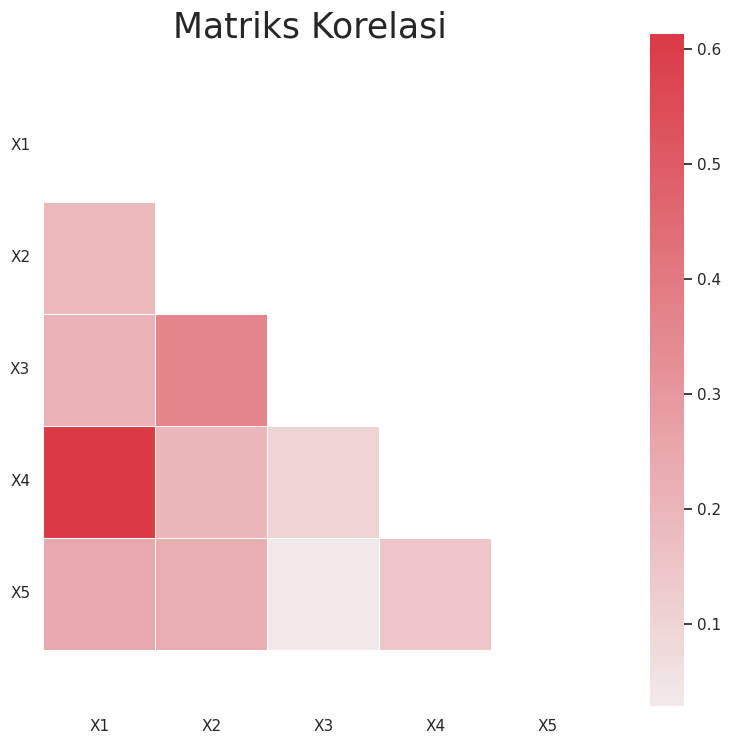

In [14]:
# Visualisasi nilai korelasi
sns.set(style='white')

# Menyembunyikan segitiga atas
mask = np.zeros_like(corr, dtype=bool) # Mengembalikan array false dengan bentuk dan tipe yang sama dengan array corr
mask[np.triu_indices_from(mask)] = True # Matriks segitiga atas disembunyikan

# Persiapan matplotlib
fig, ax = plt.subplots(figsize=(12, 8))

# Menghasilkan peta warna divergen khusus
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Gambar heatmap dengan mask dan aspek rasio yang benar
sns.heatmap(corr, cmap=cmap, center=0, square=True, mask=mask, linewidths=.5, ax=ax, fmt="s")

# Layout
plt.subplots_adjust(top=0.95)
plt.suptitle('Matriks Korelasi', fontsize=25)
plt.yticks(rotation=0)

# Fix a bug
b, t = plt.ylim() # Tentukan space nilai atas dan bawah
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.show()

# **Fuzzy C-Means**

In [15]:
# Menggunakan FCM untuk melakukan clustering (melanjutkan fungsi yang sudah dipakai di bagian awal FCM)
# Membership akhir
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T, c=4, m=2, error=0.005, maxiter=1000) # Fungsi ini akan digunakan untuk proses selanjutnya
membership = u.T
pd.DataFrame(membership)

,0,1,2,3
0,0.183418,0.368523,0.304975,0.143083
1,0.170718,0.090812,0.652710,0.085760
2,0.524356,0.099845,0.264901,0.110899
3,0.225183,0.127972,0.461289,0.185556
4,0.355807,0.120182,0.317899,0.206112
...,...,...,...,...
85,0.202154,0.161031,0.144129,0.492686
86,0.231591,0.625613,0.069994,0.072802
87,0.095265,0.800904,0.049112,0.054719
88,0.398891,0.292826,0.200577,0.107706


In [16]:
# Penentuan anggota cluster
cluster_membership = np.argmax(u, axis=0)
hasil_fcm = pd.DataFrame(cluster_membership, index=data.index)
hasil_fcm

,,0
Puskesmas,Tahun,
Nglipar I,2021,1
Nglipar II,2021,2
Gedangsari I,2021,0
Gedangsari II,2021,2
Patuk I,2021,0
...,...,...
Semanu II,2023,3
Semin I,2023,1
Semin II,2023,1


In [17]:
# Centroid akhir
center = pd.DataFrame(cntr.T)
center

,0,1,2,3
0,90.120366,90.119152,88.011134,92.561850
1,63.839491,62.438546,11.246082,70.423710
2,29.288582,10.561709,16.582180,77.318222
3,92.922470,93.507004,88.905976,91.068120
4,29.518518,71.336792,26.754378,54.626417


In [18]:
# Jarak setiap titik pada centroid akhir
jarak=pd.DataFrame(d.T)
jarak

,0,1,2,3
0,99.378754,70.110410,77.069485,112.517668
1,71.358136,97.839227,36.494188,100.679544
2,30.501284,69.898608,42.913061,66.323433
3,63.246491,83.896967,44.189397,69.673488
4,53.283791,91.681580,56.371311,70.008502
...,...,...,...,...
85,59.435605,66.593754,70.390078,38.071750
86,43.032721,26.182258,78.276166,76.751697
87,62.211418,21.455911,86.644803,82.085823
88,44.204094,51.592301,62.337483,85.068618


In [19]:
# Fungsi objektif awal sampai akhir
f_tujuan=pd.DataFrame(jm.T)
f_tujuan

,0
0,85482.913118
1,67499.991894
2,67283.271307
3,66853.778881
4,66123.619037
5,65134.344665
6,63986.771584
7,62652.058379
8,61272.292630
9,60094.844483


In [20]:
print('banyak iterasi: ', p)

banyak iterasi:  26


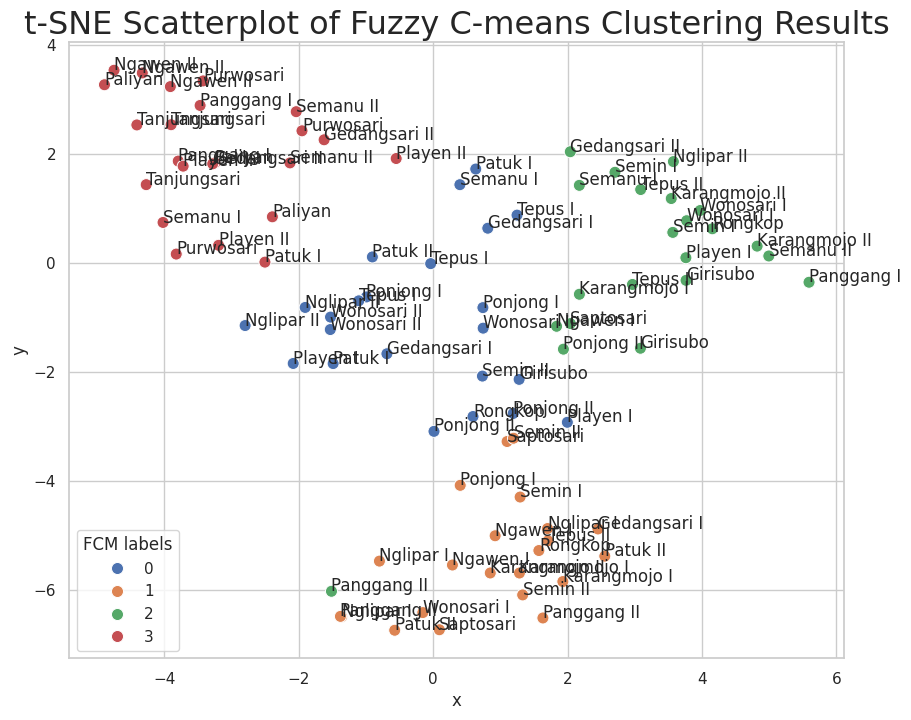

In [21]:
# Menampilkan hasil clustering
clust_labels_fcm = cluster_membership
cent_fcm = center

# Menambahkan label cluster ke kerangka data baru
data_fcm_final = data.copy()
data_fcm_final['fcm_labels'] = clust_labels_fcm

# Menerapkan t-SNE
two_dim = TSNE(random_state=0).fit_transform(data_fcm_final.drop(columns='fcm_labels'))

two_dim_final = pd.DataFrame(two_dim, index=data_fcm_final.index).merge(data_fcm_final['fcm_labels'], on=['Puskesmas','Tahun'])

two_dim_final.columns = ['x', 'y', 'FCM labels']

#

sns.set(style='whitegrid')

plt.figure(figsize=(10, 8))

# visualisasi t-SNE
sns.scatterplot(data=two_dim_final, x='x', y='y', hue='FCM labels', s=75, palette='deep')

# Tata letak
plt.title('t-SNE Scatterplot of Fuzzy C-means Clustering Results', size=23)

# Beri label titik data pada plot pencar
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']))

two_dim_labels = two_dim_final.reset_index()
label_point(two_dim_labels.x, two_dim_labels.y, two_dim_labels.Puskesmas, plt.gca())

plt.show()

In [22]:
# Profil Cluster
num_clusters = 4
data['Cluster'] = cluster_membership

# Menghitung statistik untuk setiap klaster dan variabel
cluster_stats = data.groupby('Cluster').agg(['mean', 'std', 'min', 'max'])

# Menampilkan profil klaster dalam bentuk DataFrame
pd.DataFrame(cluster_stats.T)

Cluster           0           1           2           3
X1 mean   91.414348   91.624091   81.401818   91.716087
   std     9.379221    8.400716   22.054858    9.017117
   min    63.140000   71.660000    0.000000   71.230000
   max   100.000000  100.000000  100.000000  100.000000
X2 mean   65.379565   56.533636   12.355000   71.020000
   std    17.525641   25.537100   16.319357   15.909653
   min    32.570000    0.000000    0.000000   39.900000
   max    90.970000   83.330000   40.240000  100.000000
X3 mean   27.717826    9.363636   14.416364   77.287826
   std    18.181913   11.077935   16.410193   15.252272
   min     0.000000    0.000000    0.000000   50.960000
   max    58.420000   35.660000   58.980000  100.000000
X4 mean   92.784783   94.076818   85.560000   90.634783
   std     9.138811    6.529565   21.107405   10.119635
   min    59.380000   75.690000    0.000000   64.710000
   max   100.000000  100.000000  100.000000  100.000000
X5 mean   23.993913   76.804545   24.642273   53.719130
   std    13.080126   17.557598   17.784372   24.118254
   min     0.000000   42.650000    0.000000    8.140000
   max    39.460000  100.000000   79.720000   99.130000

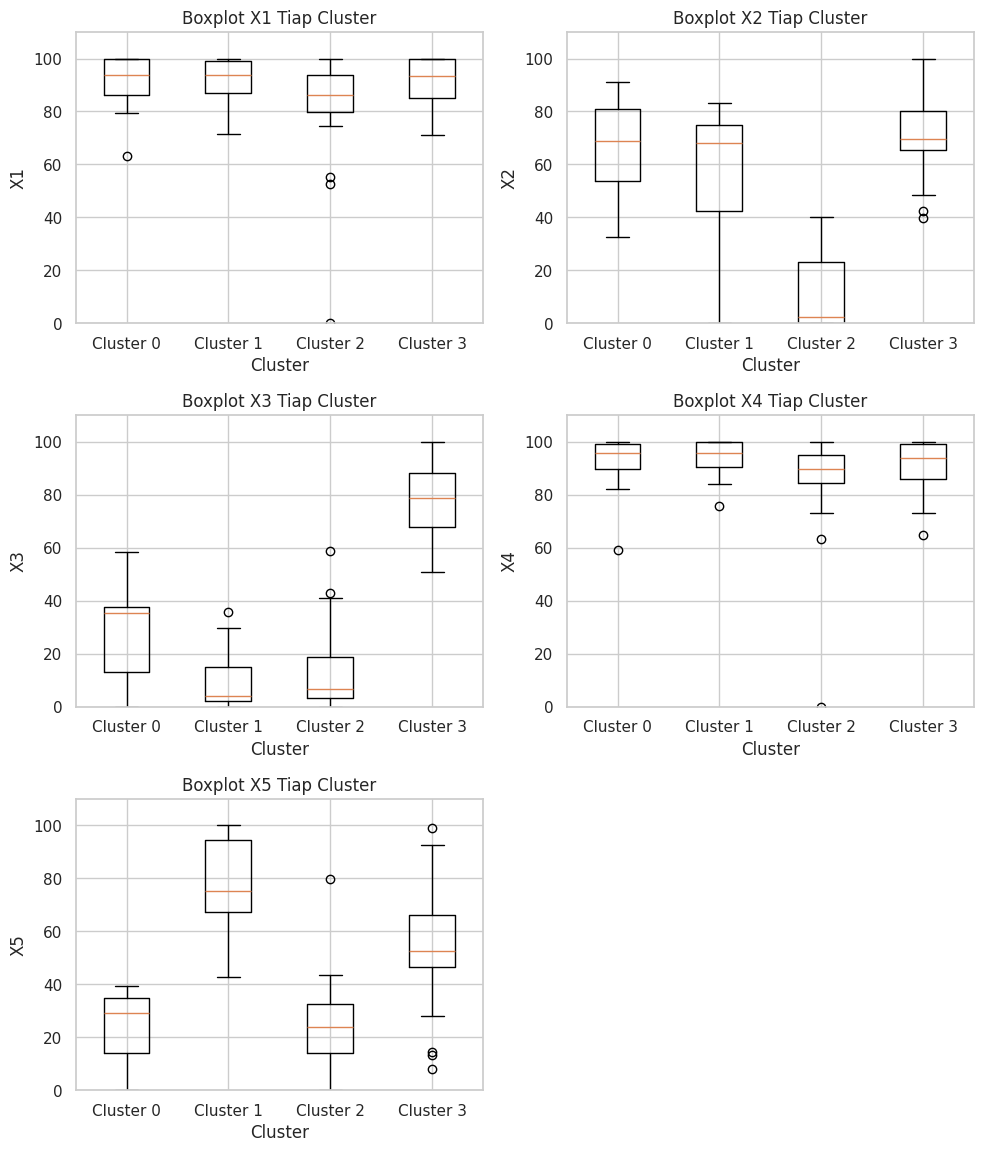

In [23]:
# Membuat satu frame dengan boxplot untuk setiap variabel dalam setiap klaster
num_features = len(data.columns) - 1  # Jumlah fitur (tanpa kolom Cluster)

plt.figure(figsize=(10, 15))  # Ukuran frame boxplot

for feature_index in range(num_features):
    plt.subplot(4, 2, feature_index + 1)  # 4 baris, 2 kolom, indeks subplot dimulai dari 1
    plt.title(f'Boxplot X{feature_index + 1} Tiap Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(f'X{feature_index + 1}')

    feature_name = data.columns[feature_index]
    boxplot_data = [data[data['Cluster'] == cluster][feature_name].values for cluster in range(num_clusters)]

    plt.boxplot(boxplot_data, labels=[f'Cluster {i}' for i in range(num_clusters)])

    # Menyesuaikan skala pada sumbu y (y-axis)
    min_val = min([np.min(box) for box in boxplot_data])
    max_val = max([np.max(box) for box in boxplot_data])
    plt.ylim(min_val - 0.1 * abs(min_val), max_val + 0.1 * abs(max_val))

plt.tight_layout()
plt.show()

# **Evaluasi Fuzzy C-Means**

In [24]:
# Skor Shilhouette
for i in range (2,6):
        # Memasukkan data ke dalam model FCM
        num_clusters = i
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T, num_clusters, 2, error=0.005, maxiter=1000)
        # Mendapatkan label kluster dari tingkat keanggotaan
        cluster_membership = np.argmax(u, axis=0)
        sc_score =silhouette_score(data, cluster_membership)
        print('Cluster =', i , 'Memiliki silhouette coefficient ', sc_score)

Cluster = 2 Memiliki silhouette coefficient  0.25528796082669797
Cluster = 3 Memiliki silhouette coefficient  0.284485963310907
Cluster = 4 Memiliki silhouette coefficient  0.2860487684399082
Cluster = 5 Memiliki silhouette coefficient  0.25707162898247377


In [25]:
# Calinski-Harabasz Index
for i in range (2,6):
        # Memasukkan data ke dalam model FCM
        num_clusters = i
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T, num_clusters, 2, error=0.005, maxiter=1000)
        # Mendapatkan label kluster dari tingkat keanggotaan
        cluster_membership = np.argmax(u, axis=0)
        chi_score =calinski_harabasz_score(data, cluster_membership)
        print('Cluster =', i , 'Memiliki Calinski-Harabasz Index', chi_score)

Cluster = 2 Memiliki Calinski-Harabasz Index 35.88859629206954
Cluster = 3 Memiliki Calinski-Harabasz Index 39.332354205958865
Cluster = 4 Memiliki Calinski-Harabasz Index 40.796279121141545
Cluster = 5 Memiliki Calinski-Harabasz Index 35.93236419747552


In [26]:
# Davies-Bouldin Index
for i in range (2,6):
        # Memasukkan data ke dalam model FCM
        num_clusters = i
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T, num_clusters, 2, error=0.005, maxiter=1000)
        # Mendapatkan label kluster dari tingkat keanggotaan
        cluster_membership = np.argmax(u, axis=0)
        dbi_score =davies_bouldin_score(data, cluster_membership )
        print('Cluster =', i , 'Memiliki Davies-Bouldin Index', dbi_score)

Cluster = 2 Memiliki Davies-Bouldin Index 1.4386943540809733
Cluster = 3 Memiliki Davies-Bouldin Index 1.240876503073067
Cluster = 4 Memiliki Davies-Bouldin Index 1.104849814996414
Cluster = 5 Memiliki Davies-Bouldin Index 1.2076753757611745
